In [2]:
import os
import gc

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import numpy.ma as ma

from hbmep.config import Config
from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from models import NonHierarchicalBayesianModel
from constants import (
    DATA_PATH,
    TOML_PATH
)

import math


In [3]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import numpy.ma as ma

file = open("/home/andres/repos/rat-mapping-paper/reports/C_SMA_LAR/combine.pkl","rb")
combinations = pickle.load(file)
df = pd.read_csv("/home/andres/data/hbmep-processed/C_SMA_LAR/data.csv")
df['compound_position'].unique().tolist()
subjects = df["participant"].unique().tolist()
sizes = [ 'B', 'S']
# positions = sorted([p for p in positions if (p.split('-')[0] == "" or p.split('-')[1] == "")])
targets = ['LL','L', 'LM','LM1', 'LM2', 'M']
levels = ['C5', 'C6']
# positions = [p for p in positions if (p.split('-')[1][2] in targets and p.split('-')[1][1] != "7")]
muscles = set([m[3] for m in combinations.keys()])
arr = []
mask = []

for subject in subjects:
    for level in levels:
        for target in targets:
            for size in sizes:
                for muscle in muscles:
                    position = f"-{level}{target}"
                    key = (subject, position, size, muscle)
                    if key in combinations.keys():
                        currenta = combinations[key]['a']
                        currenta = currenta.reshape(-1, 1)
                        arr.append(currenta)
                        mask.append(np.full((4000, 1), False))
                    else:
                        arr.append(np.zeros(4000).reshape(-1, 1))
                        mask.append(np.full((4000, 1), True))

arr = np.array(arr)
arr = arr.reshape(len(subjects), len(levels), len(targets), len(sizes), len(muscles), *arr.shape[1:])
mask = np.array(mask)
mask = mask.reshape(len(subjects), len(levels), len(targets), len(sizes), len(muscles), *mask.shape[1:])

arr = ma.masked_array(arr, mask=mask)
arr = arr[..., 0]

arr.shape #subects, levels, targets, sizes, muscles


FileNotFoundError: [Errno 2] No such file or directory: '/home/andres/data/hbmep-processed/C_SMA_LAR/data.csv'

In [ ]:
compound

In [19]:
[encoder_dict[model.features[1]]]



array([30,  1, 31,  5,  2,  0, 29, 43, 35,  4, 59, 55,  8, 21, 58, 23,  7,
        6, 42, 27, 11, 22, 12,  3, 28, 14, 40, 24, 34, 25, 26, 56, 57, 54,
       20, 13, 41, 37, 63, 69, 65, 15, 68, 62, 16, 17, 19, 60, 66, 67, 64,
       18, 61, 50, 33, 32, 36, 49, 53, 45, 48, 44, 52, 47, 10, 46,  9, 39,
       51, 38])

In [17]:
z = [k[1] for k in combinations.keys()]
z = list(set(z))
z = sorted(z)
z

['-C5L',
 '-C5LL',
 '-C5LM',
 '-C5LM1',
 '-C5LM2',
 '-C5M',
 '-C6L',
 '-C6LL',
 '-C6LM',
 '-C6LM1',
 '-C6LM2',
 '-C6M',
 '-C6R',
 '-C6RM',
 '-C6RR',
 '-C7LM',
 '-C7M',
 '-C7R',
 '-C7RM',
 '-C7RR',
 'C5L-C5LL',
 'C5LM1-C5L',
 'C5LM1-C5LL',
 'C5LM2-C5L',
 'C5LM2-C5LL',
 'C5LM2-C5LM1',
 'C5LM2-C5M',
 'C5LM2-C6L',
 'C5LM2-C6LL',
 'C5M-C5L',
 'C5M-C5LL',
 'C5M-C5LM',
 'C5M-C5LM1',
 'C5M-C5LM2',
 'C5M-C6L',
 'C5M-C6LL',
 'C6L-C6LL',
 'C6LL-C6L',
 'C6LM-C6L',
 'C6LM-C6LL',
 'C6LM-C6M',
 'C6LM-C6R',
 'C6LM-C6RM',
 'C6LM-C6RR',
 'C6LM1-C6L',
 'C6LM1-C6LL',
 'C6LM2-C6L',
 'C6LM2-C6LL',
 'C6LM2-C6LM1',
 'C6M-C6L',
 'C6M-C6LL',
 'C6M-C6LM',
 'C6M-C6LM1',
 'C6M-C6LM2',
 'C6M-C6R',
 'C6M-C6RM',
 'C6M-C6RR',
 'C6R-C6RR',
 'C6RM-C6R',
 'C6RM-C6RR',
 'C7LM-C7M',
 'C7LM-C7R',
 'C7LM-C7RM',
 'C7LM-C7RR',
 'C7M-C7R',
 'C7M-C7RM',
 'C7M-C7RR',
 'C7R-C7RR',
 'C7RM-C7R',
 'C7RM-C7RR']

In [35]:
size

['B', 'S']

In [36]:
a[0, 0, 0, 0, 0, :, 0].shape

(4000,)

In [46]:
combinations[('amap03',
  'C5M-C5LL',
  'S',
  'LADM')]['a'][:, 0, 0, 0, 0].mean() - a[2, 0, 0, 0, 1, :, 0].mean()

314.9502515406897

In [27]:
a.shape

(8, 2, 3, 6, 2, 4000, 6)

In [22]:
arr[..., 0].shape

(8, 2, 6, 2, 6)

In [23]:
(a[:, 1, ...][:, [0, 1], ...][..., 0] - arr[..., 0, :]).max()

1134.0876268536372

In [4]:
USER = os.environ["USER"]
 
 
src = f"/home/{USER}/repos/rat-mapping-paper/reports/C_SMA_LAR/processed_inference_efficacy.pkl"
with open(src, "rb") as f:
    (
        df,
        encoder_dict,
        model,
        posterior_samples,
        a,
        subjects,
        contacts,
        positions,
        left_degrees,
        size,
    ) = pickle.load(f)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [6]:
contact_ind = 0 # mono or bi
size_ind = 0 # big or small

In [44]:
a.data

array([[[[[[[308.63033349, 303.2580708 , 363.06747755, 223.11401502,
             202.3913136 , 303.88559821],
            [157.57757378, 376.82747218, 166.59606047, 381.1819915 ,
             228.87082553, 394.41229451],
            [164.42666997, 284.73246291, 265.81570375, 311.83076693,
             294.18542372, 292.13698821],
            ...,
            [371.4641906 , 134.50585837, 259.86214574, 285.64144679,
             213.01332903, 154.00172577],
            [219.57369339, 138.25617883, 168.61398189, 170.19375794,
             165.22334991, 328.59607178],
            [222.72079018, 129.02760343, 184.68990772, 190.10457692,
             163.800514  , 242.11966094]],

           [[182.51011476,  83.44230851, 205.19477459, 130.82954102,
             139.09510476, 121.44757294],
            [184.42784473,  79.41858339, 197.09147336, 127.98678582,
             146.9670535 , 107.21327805],
            [173.97441329,  80.94663331, 198.95583039, 127.53364028,
             133.4488780

In [41]:
posterior_samples['a'].shape

(4000, 8, 70, 3, 6)

In [50]:
a.shape #sub, contacts (mono , bi), pos, lat, size

(8, 2, 3, 6, 2, 4000, 6)

In [8]:
a_test = a[:,contact_ind,:,:,size_ind,...]
a_test = a_test / ma.median(a_test, axis = (1,2,-1), keepdims=True)

a_mean = ma.mean(a_test, axis=(1,-2, -1))
a_test.shape

(8, 3, 6, 4000, 6)

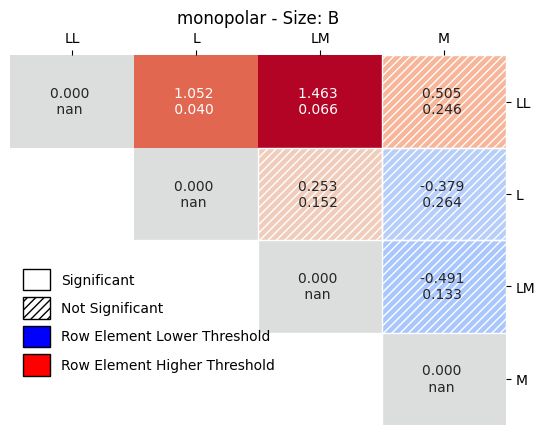

In [8]:
contact_ind = 0 # mono or bi
size_ind = 0 # big or small

### NEEDS TO BE CHANGED WHEN CHANGING SIZE/CONTACT
### ['LL', 'L', 'LM', 'LM1', 'LM2', 'M']
ind = [0, 1, 2,5]


### ACTUAL CALCULATION
a_test = a[:,contact_ind,:,:,size_ind,...]
a_test = a_test / ma.median(a_test, axis = (1,2,-1), keepdims=True)

a_mean = ma.mean(a_test, axis=(1,-2, -1))
a_mean.shape

t = (a_mean[:, :, None] - a_mean[:, None, :])
test = stats.ttest_1samp(t, popmean=0, alternative="two-sided", axis=(0))

### GET MEAN TO PLOT
p_mean = t.mean(axis=0)
### GET P VALUES
p = test.pvalue
### MASK NANs
p_mean = p_mean[~p_mean.mask]
p_mean = p_mean.reshape(len(ind),len(ind))

### GET VALUES WE WANT TO PLOT
p_ = p[ind, :][:, ind]

#FOR ANNOTATION
data = []
for ind_i, i in enumerate(p_):
    for ind_j, j in enumerate(i):
        data.append(f"{p_mean[ind_i, ind_j]:.3f} \n {j:.3f}  ")
        
data = np.array(data).reshape(len(ind),len(ind))

#MASK LOWER TRIANGLE
mask2= np.array(p_)
mask2 = np.tril(np.ones_like(mask2), k=-1).astype(bool)

#CORRECT LABELS
labels = np.array(left_degrees)
labels = labels.astype('U20')

if contact_ind == 0:
    labels[ind] = labels[ind]
else:
    labels[ind] = np.char.add(labels[ind],"-M")

#PLOT
ax=sns.heatmap(p_mean, xticklabels=labels[ind], yticklabels=labels[ind],annot=data,fmt = '',center = 0, cmap = "coolwarm",cbar = False, mask = mask2)


##ADD HATCH FOR SIGNIFICANCE
handles = []
hatch_mask = p_ > 0.1

for i in range (p_.shape[0]):
    for j in range(p_.shape[1]):
        if hatch_mask[i, j]:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='', label="Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='////', label="Not Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                    hatch='', label="Row Element Lower Threshold"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                    hatch='', label="Row Element Higher Threshold"))
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
        handlelength=2, handleheight=2, frameon=False)
ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

ax.yaxis.tick_right()
ax.title.set_text(f"{contacts[contact_ind]}polar - Size: {size[size_ind]}")

In [25]:
def musc_ind(musc, contact, size_i):
    contact_ind = contact # mono or bi
    size_ind = size_i # big or small
    musc_ind = musc

    ### NEEDS TO BE CHANGED WHEN CHANGING SIZE/CONTACT
    ### ['LL', 'L', 'LM', 'LM1', 'LM2', 'M']
    if size_ind == 0:
        ind = [0, 1, 2,5]
    else: 
        ind = [0, 1, 3,4,5]


    ### ACTUAL CALCULATION
    a_test = a[:,contact_ind,:,:,size_ind,:,musc_ind]
    a_test = a_test / ma.median(a_test, axis = (1,2), keepdims=True)

    a_mean = ma.mean(a_test, axis=(1, -1))
    a_mean.shape

    t = (a_mean[:, :, None] - a_mean[:, None, :])
    test = stats.ttest_1samp(t, popmean=0, alternative="two-sided", axis=(0))

    ### GET MEAN TO PLOT
    p_mean = t.mean(axis=0)
    ### GET P VALUES
    p = test.pvalue
    ### MASK NANs
    p_mean = p_mean[~p_mean.mask]
    p_mean = p_mean.reshape(len(ind),len(ind))

    ### GET VALUES WE WANT TO PLOT
    p_ = p[ind, :][:, ind]

    #FOR ANNOTATION
    data = []
    for ind_i, i in enumerate(p_):
        for ind_j, j in enumerate(i):
            data.append(f"{p_mean[ind_i, ind_j]:.3f} \n {j:.3f}  ")
            
    data = np.array(data).reshape(len(ind),len(ind))

    #MASK LOWER TRIANGLE
    mask2= np.array(p_)
    mask2 = np.tril(np.ones_like(mask2), k=-1).astype(bool)

    #CORRECT LABELS
    labels = np.array(left_degrees)
    labels = labels.astype('U20')

    if contact_ind == 0:
        labels[ind] = labels[ind]
    else:
        labels[ind] = np.char.add(labels[ind],"-M")

    #PLOT
    ax=sns.heatmap(p_mean, xticklabels=labels[ind], yticklabels=labels[ind],annot=data,fmt = '',center = 0, cmap = "coolwarm",cbar = False, mask = mask2)


    ##ADD HATCH FOR SIGNIFICANCE
    handles = []
    hatch_mask = p_ > 0.1

    for i in range (p_.shape[0]):
        for j in range(p_.shape[1]):
            if hatch_mask[i, j]:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                        hatch='', label="Significant"))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                        hatch='////', label="Not Significant"))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                        hatch='', label="Row Element Lower Threshold"))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                        hatch='', label="Row Element Higher Threshold"))
    ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
            handlelength=2, handleheight=2, frameon=False)
    ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

    ax.yaxis.tick_right()
    ax.title.set_text(f"{contacts[contact_ind]}polar - Size: {size[size_ind]} - Muscle: {model.response[musc]}")

In [24]:
sizes

NameError: name 'sizes' is not defined

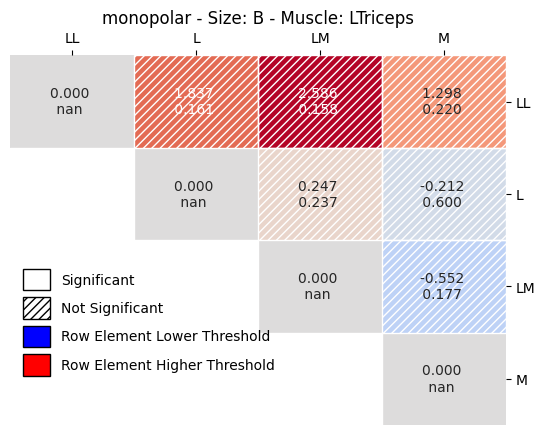

In [32]:
musc_ind(5, 0, 0)

# Comparing Big vs Small

In [53]:
### ACTUAL CALCULATION
a_big = a[:,contact_ind,:,:,0,...]
a_small = a[:,contact_ind,:,:,1,...]

a_big = a_big / ma.median(a_big, axis = (1,2,-1), keepdims=True)
a_small = a_small / ma.median(a_small, axis = (1,2,-1), keepdims=True)

a_big_mean = ma.mean(a_big, axis=(1,-2, -1))
a_small_mean = ma.mean(a_small, axis=(1,-2, -1))

t = (a_big_mean[:,:] - a_small_mean[:,:])
test = stats.ttest_1samp(t, popmean=0, alternative="two-sided", axis=(0))

### GET MEAN TO PLOT
p_mean = t.mean(axis=0)
### GET P VALUES
p = test.pvalue

In [125]:
contact_ind = 1

In [126]:
a_big = a[:,contact_ind,:,:,0,...]
a_small = a[:,contact_ind,:,:,1,...]
a_small.shape

(8, 3, 6, 4000, 6)

In [122]:
left_degrees

['LL', 'L', 'LM', 'LM1', 'LM2', 'M']

In [127]:
a_small = a_small[..., [0, 1, 3, 4, -1], :, :]
a_big = a_big[..., [0, 1, 2, 2, -1], :, :]
assert a_big.shape == a_small.shape


In [79]:
a_big = a_big / ma.median(a_big, axis = (1,2,-1), keepdims=True)
a_small = a_small / ma.median(a_small, axis = (1,2,-1), keepdims=True)


In [128]:
a_big_mean = ma.mean(a_big, axis=(-2))
a_small_mean = ma.mean(a_small, axis=(-2))
a_small_mean.shape


(8, 3, 5, 6)

In [91]:
a_big_mean = ma.mean(a_big, axis=(1,-2, -1))
a_small_mean = ma.mean(a_small, axis=(1,-2, -1))
a_small_mean.shape

(8, 5)

In [129]:
t = (a_big_mean - a_small_mean)
t.shape
test = stats.ttest_1samp(t, popmean=0, alternative="two-sided", axis=(0, 1, -1))


In [130]:
p = test.pvalue
p

array([1.30752030e-04, 9.38296429e-04, 1.18398044e-01, 2.42126787e-01,
                  nan])

In [134]:
left_degrees

['LL', 'L', 'LM', 'LM1', 'LM2', 'M']

In [132]:
test.confidence_interval()

ConfidenceInterval(low=array([ -99.84676769, -100.61503423, -117.02753494, -100.08221469,
                 nan]), high=array([-34.53124765, -28.23401489,  14.15738161,  26.57403462,
                nan]))

In [ ]:
### GET MEAN TO PLOT
p_mean = t.mean(axis=0)
### GET P VALUES



# Electrode config graphing

Text(0.5, 1.0, 'Thresholds for bipolar')

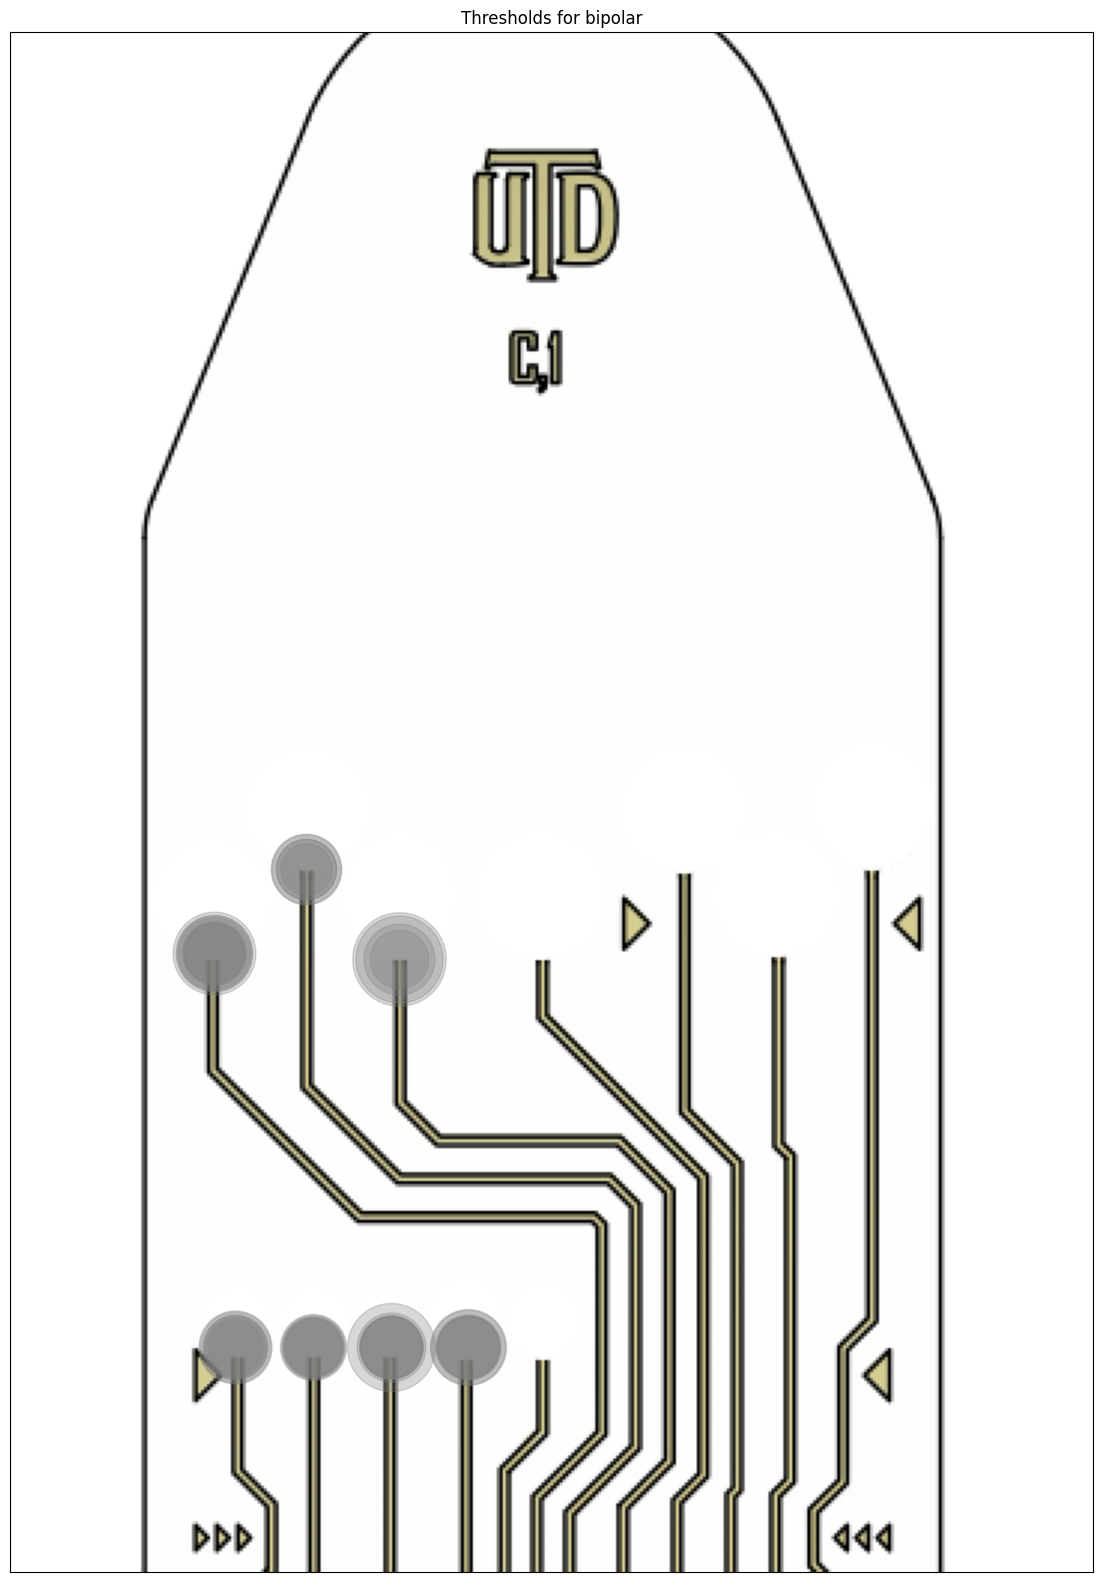

In [124]:
contact_ind = 1 # mono or bi
size_ind = 1 # big or small

### NEEDS TO BE CHANGED WHEN CHANGING SIZE/CONTACT
### ['LL', 'L', 'LM', 'LM1', 'LM2', 'M']

### ACTUAL CALCULATION
a_big = a[:,contact_ind,:,:,0,...]
a_big = a_big / ma.median(a[:,contact_ind,:,:,0,...], axis = (1,2,3,-1), keepdims=True)

a_small = a[:,contact_ind,:,:,1,...]
a_small = a_small / ma.median(a[:,contact_ind,:,:,1,...], axis = (1,2,3,-1), keepdims=True)

a_mean_big = ma.mean(a_big, axis=(1,-2, -1))
a_mean_small = ma.mean(a_small, axis=(1,-2, -1))


x_vals_big = {"LL":(67.7, 308), "L":(98.7, 280), "LM":(130, 310), "M": (178, 308)}
x_vals_small = {"LL":(75, 440), "L":(101, 440), "LM1":(127, 440), "LM2": (153, 440), "M": (178, 440)}
    
pvalues = []
mask = []
data = []
mean_list_big = []
mean_list_small = []

for sub_ind, s in enumerate(subjects):
    for l_ind, l in enumerate(left_degrees):
        if a_mean_big.mask[sub_ind,l_ind].all():
                continue
            
        mean_list_big.append(
            (
                subjects[sub_ind],
                left_degrees[l_ind],
                a_mean_big[sub_ind,l_ind]
            )
        )
        
for sub_ind, s in enumerate(subjects):
    for l_ind, l in enumerate(left_degrees):
        if a_mean_small.mask[sub_ind,l_ind].all():
                continue
            
        mean_list_small.append(
            (
                subjects[sub_ind],
                left_degrees[l_ind],
                a_mean_small[sub_ind,l_ind]
            )
        )


im = plt.imread("/home/andres/C_SMA_LAR_white2.png")

plt.figure(figsize=(20, 20))



for i, z in enumerate(mean_list_big):
    if z[1] not in x_vals_big:
        continue
    eff_size = mean_list_big[i][2]*2000
    plt.scatter(x_vals_big[z[1]][0], x_vals_big[z[1]][1], s = eff_size,alpha=0.3, color="grey")
    
for i, z in enumerate(mean_list_small):
    if z[1] not in x_vals_small:
        continue
    eff_size = mean_list_small[i][2]*2000
    plt.scatter(x_vals_small[z[1]][0], x_vals_small[z[1]][1], s = eff_size,alpha=0.3, color="grey")

implot = plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.title(f"Thresholds for {contacts[contact_ind]}polar")


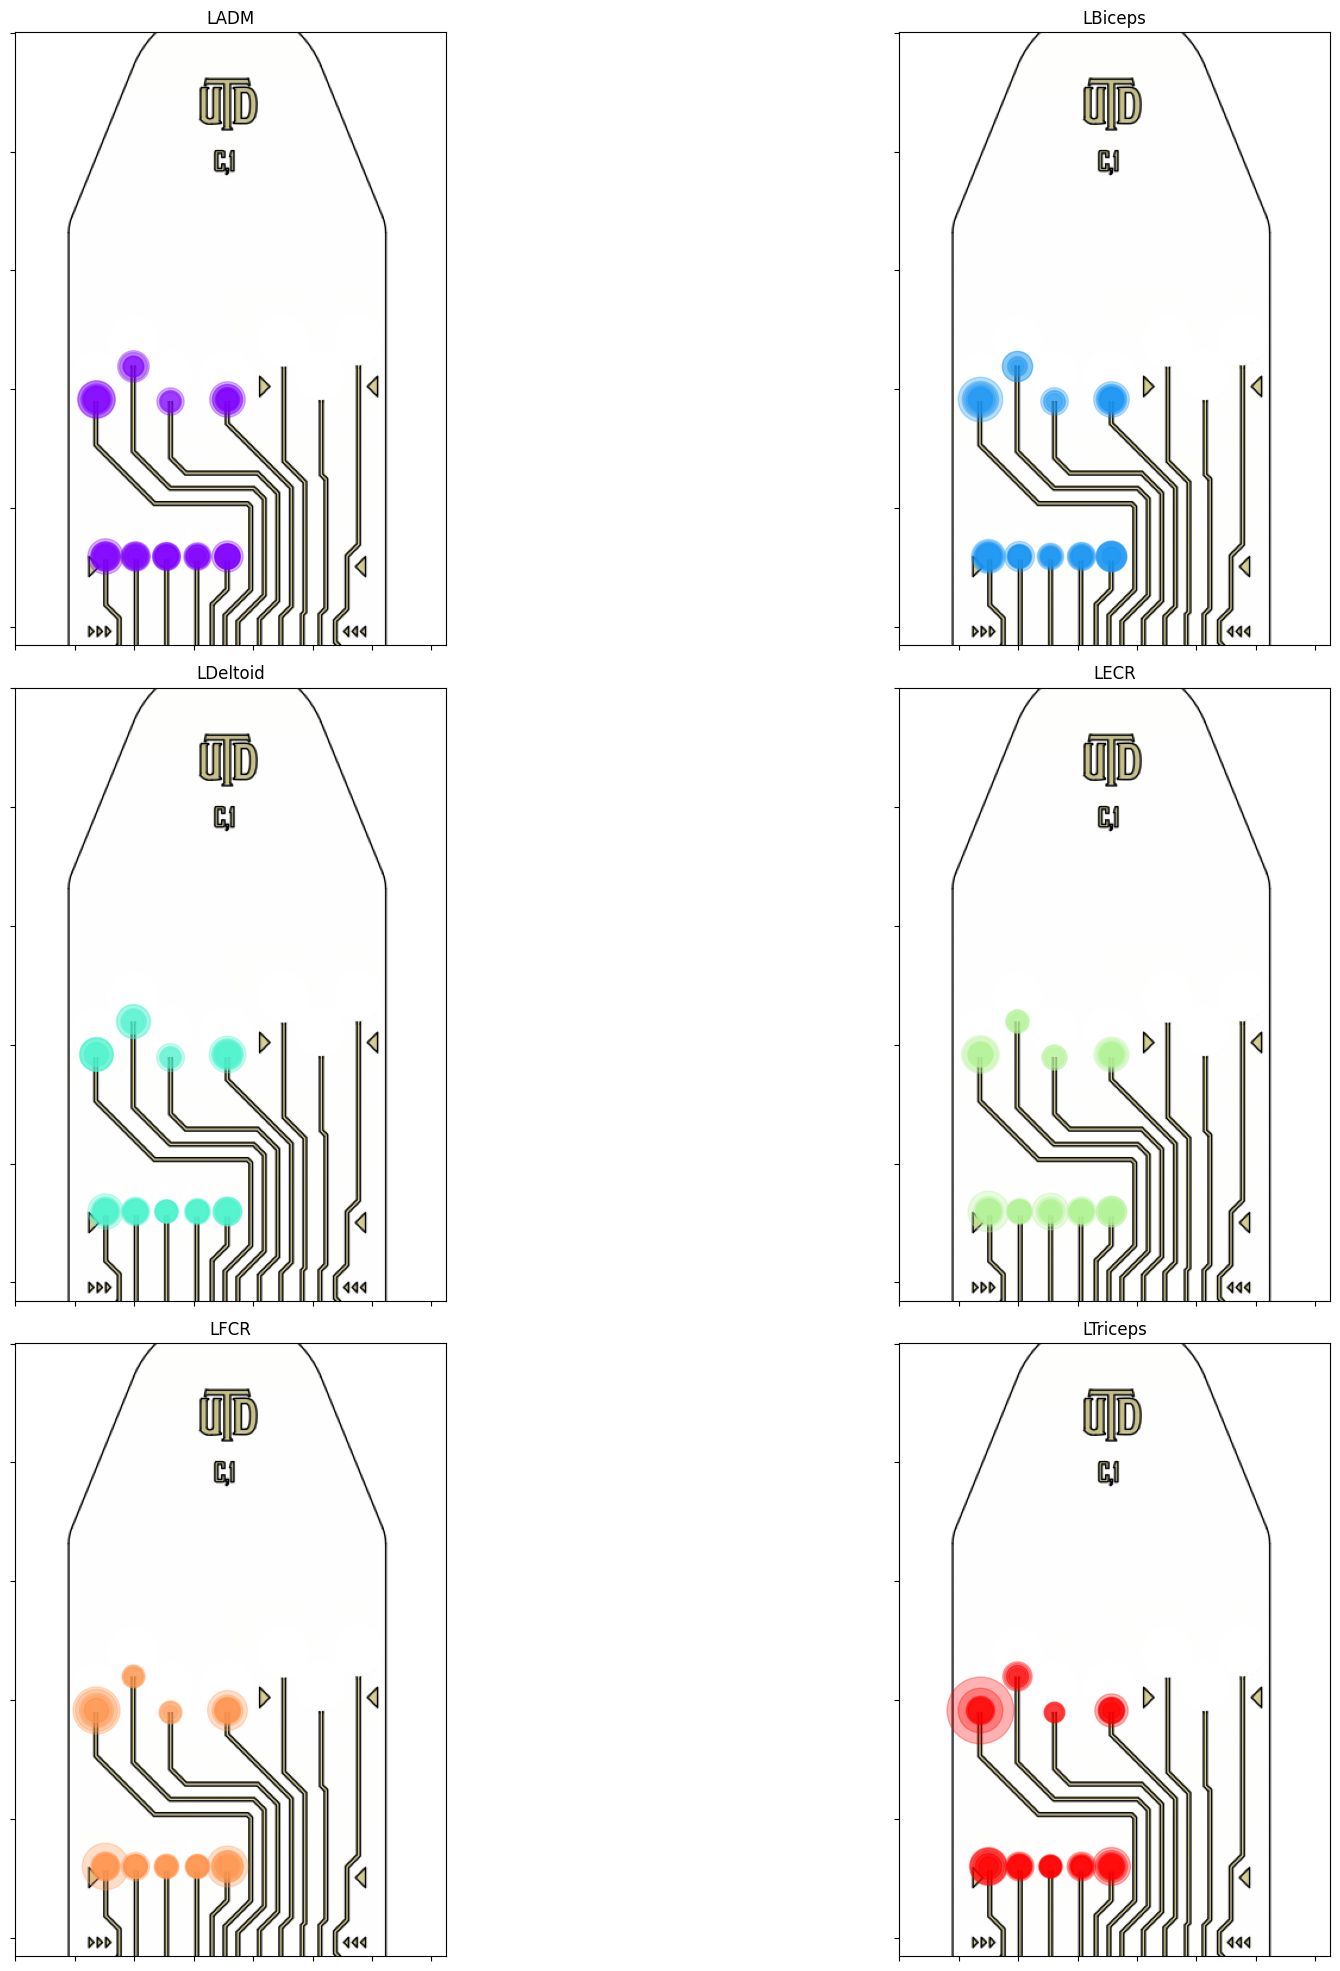

In [131]:
contact_ind = 0 # mono or bi


### NEEDS TO BE CHANGED WHEN CHANGING SIZE/CONTACT
### ['LL', 'L', 'LM', 'LM1', 'LM2', 'M']

### ACTUAL CALCULATION

x_vals_big = {"LL":(67.7, 308), "L":(98.7, 280), "LM":(130, 310), "M": (178, 308)}
x_vals_small = {"LL":(75, 440), "L":(101, 440), "LM1":(127, 440), "LM2": (153, 440), "M": (178, 440)}

fig, ax = plt.subplots(3, 2, figsize=(20,20))    
ax = ax.flatten()

im = plt.imread("/home/andres/C_SMA_LAR_white2.png")

for musc,m in enumerate(model.response):

    a_big = a[:,contact_ind,:,:,0,:,musc]
    a_big = a_big / ma.median(a[:,contact_ind,:,:,0,:,musc], axis = (1,2,3), keepdims=True)

    a_small = a[:,contact_ind,:,:,1,:,musc]
    a_small = a_small / ma.median(a[:,contact_ind,:,:,1,:,musc], axis = (1,2,3), keepdims=True)

    a_mean_big = ma.mean(a_big, axis=(1,-1))
    a_mean_small = ma.mean(a_small, axis=(1,-1))
    
    
    pvalues = []
    mask = []
    data = []
    mean_list_big = []
    mean_list_small = []

    for sub_ind, s in enumerate(subjects):
        for l_ind, l in enumerate(left_degrees):
            if a_mean_big.mask[sub_ind,l_ind].all():
                    continue
                
            mean_list_big.append(
                (
                    subjects[sub_ind],
                    left_degrees[l_ind],
                    a_mean_big[sub_ind,l_ind]
                )
            )
            
    for sub_ind, s in enumerate(subjects):
        for l_ind, l in enumerate(left_degrees):
            if a_mean_small.mask[sub_ind,l_ind].all():
                    continue
                
            mean_list_small.append(
                (
                    subjects[sub_ind],
                    left_degrees[l_ind],
                    a_mean_small[sub_ind,l_ind]
                )
            )



    # plt.figure(figsize=(20, 20))
        
    for i, z in enumerate(mean_list_big):
        if z[1] not in x_vals_big:
            continue
        eff_size = mean_list_big[i][2]*300
        ax[musc].scatter(x_vals_big[z[1]][0], x_vals_big[z[1]][1], s = eff_size,alpha=0.3, color = model._get_colors(model.n_response)[musc])
        
    for i, z in enumerate(mean_list_small):
        if z[1] not in x_vals_small:
            continue
        eff_size = mean_list_small[i][2]*300
        ax[musc].scatter(x_vals_small[z[1]][0], x_vals_small[z[1]][1], s = eff_size,alpha=0.3, color = model._get_colors(model.n_response)[musc])
    plt.tight_layout()
    implot = ax[musc].imshow(im)
    ax[musc].set_xticklabels([])
    ax[musc].set_yticklabels([])
    ax[musc].set_title(f"{model.response[musc]}")
    


In [101]:
enumerate(model.response)

In [89]:
a_big = a[:,contact_ind,:,:,0,...]
a_big = a_big / ma.median(a[:,contact_ind,:,:,0,...], axis = (1,2,3,-1), keepdims=True)
a_big.shape

(8, 3, 6, 4000, 6)

In [1]:
import matplotlib.pyplot as plt


In [2]:
im = plt.imread("/home/andres/repos/rat-mapping-paper/figures/efficiency_bipolar.png")
plt.imshow(im)

FileNotFoundError: [Errno 2] No such file or directory: '/home/andres/repos/rat-mapping-paper/figures/efficiency_bipolar.png'

# Right Biceps

In [21]:
USER = os.environ["USER"]
 
src = f"/home/andres/repos/rat-mapping-paper/reports/non-hierarchical/C_SMA_LAR/non_hierarchical_bayesian_model/rbiceps.pkl"
# src = f"/home/{USER}/repos/rat-mapping-paper/reports/C_SMA_LAR/rbiceps.pkl"
with open(src, "rb") as f:
    (
    df_rbiceps, encoder_dict_rbiceps, model_rbiceps, posterior_sample_rbiceps
    ) = pickle.load(f)

In [78]:
a_rbiceps = posterior_sample_rbiceps[site.a]
a_rbiceps.shape

(4000, 8, 70, 3, 1)

In [65]:
compound_position = encoder_dict_rbiceps[model_rbiceps.features[1]].inverse_transform(sorted(df_rbiceps['compound_position'].unique()))

In [85]:
compound_position

array(['-C5L', '-C5LL', '-C5LM', '-C5LM1', '-C5LM2', '-C5M', '-C6L',
       '-C6LL', '-C6LM', '-C6LM1', '-C6LM2', '-C6M', '-C6R', '-C6RM',
       '-C6RR', '-C7LM', '-C7M', '-C7R', '-C7RM', '-C7RR', 'C5L-C5LL',
       'C5LM1-C5L', 'C5LM1-C5LL', 'C5LM2-C5L', 'C5LM2-C5LL',
       'C5LM2-C5LM1', 'C5LM2-C5M', 'C5LM2-C6L', 'C5LM2-C6LL', 'C5M-C5L',
       'C5M-C5LL', 'C5M-C5LM', 'C5M-C5LM1', 'C5M-C5LM2', 'C5M-C6L',
       'C5M-C6LL', 'C6L-C6LL', 'C6LL-C6L', 'C6LM-C6L', 'C6LM-C6LL',
       'C6LM-C6M', 'C6LM-C6R', 'C6LM-C6RM', 'C6LM-C6RR', 'C6LM1-C6L',
       'C6LM1-C6LL', 'C6LM2-C6L', 'C6LM2-C6LL', 'C6LM2-C6LM1', 'C6M-C6L',
       'C6M-C6LL', 'C6M-C6LM', 'C6M-C6LM1', 'C6M-C6LM2', 'C6M-C6R',
       'C6M-C6RM', 'C6M-C6RR', 'C6R-C6RR', 'C6RM-C6R', 'C6RM-C6RR',
       'C7LM-C7M', 'C7LM-C7R', 'C7LM-C7RM', 'C7LM-C7RR', 'C7M-C7R',
       'C7M-C7RM', 'C7M-C7RR', 'C7R-C7RR', 'C7RM-C7R', 'C7RM-C7RR'],
      dtype=object)

In [87]:
mono = [c for c in compound_position if c.split("-")[0] == "" or c.split("-")[1] == ""]
mono

['-C5L',
 '-C5LL',
 '-C5LM',
 '-C5LM1',
 '-C5LM2',
 '-C5M',
 '-C6L',
 '-C6LL',
 '-C6LM',
 '-C6LM1',
 '-C6LM2',
 '-C6M',
 '-C6R',
 '-C6RM',
 '-C6RR',
 '-C7LM',
 '-C7M',
 '-C7R',
 '-C7RM',
 '-C7RR']

In [88]:
laterality_r = ['M','RM','R','RR']

In [89]:
mono = [m for m in mono if m.split("-")[1][2] in laterality_r]
mono

['-C5M', '-C6M', '-C6R', '-C6RM', '-C6RR', '-C7M', '-C7R', '-C7RM', '-C7RR']

In [92]:
contact_ind = encoder_dict_rbiceps[model_rbiceps.features[1]].transform(mono)
contact_ind

array([ 5, 11, 12, 13, 14, 16, 17, 18, 19])

In [91]:
a_rbiceps.shape

(4000, 8, 70, 3, 1)

In [93]:
a_test = a_rbiceps[..., contact_ind, :, :]
a_test.shape

(4000, 8, 9, 3, 1)

In [94]:
mono

['-C5M', '-C6M', '-C6R', '-C6RM', '-C6RR', '-C7M', '-C7R', '-C7RM', '-C7RR']

In [95]:
laterality_r

['M', 'RM', 'R', 'RR']

In [97]:
mono.index("-C6M")

1

In [103]:
'-C5RM' in mono

False

In [111]:
a_test.shape

(4000, 8, 9, 3, 1)

In [112]:
np.isnan(a_test).sum() / 4000

155.0

In [116]:
a_test.shape

(4000, 8, 9, 3, 1)

In [115]:
np.isnan(a_test).shape

(4000, 8, 9, 3, 1)

In [122]:
segments = ["-C5", "-C6", "-C7"]

arr_biceps = []
mask_biceps = [] 

# for subject in subjects:
#     for size in sizes:  
for segment in segments:
    for lat in laterality_r:
        cpos = f"{segment}{lat}"
        if cpos in mono:
            arr_biceps.append(a_rbiceps[:,:,mono.index(cpos),...])

        else:
            arr_biceps.append(np.full(a_rbiceps[:, :, 0, ...].shape, np.nan))

arr_biceps = np.array(arr_biceps)
arr_biceps = arr_biceps.reshape(len(segments), len(laterality_r), *arr_biceps.shape[1:])
arr_biceps.shape


(3, 4, 4000, 8, 3, 1)

In [168]:
arr_biceps = ma.masked_invalid(arr_biceps)

In [157]:
t = np.nanmean(arr_biceps[..., 0, :], axis=(0, 2, -1))


/tmp/ipykernel_266592/3473915515.py:1: RuntimeWarning: Mean of empty slice
  t = np.nanmean(arr_biceps[..., 0, :], axis=(0, 2, -1))


In [162]:
q = (t[:, None, :] - t[None, :, :])


array([[[   0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,           nan,    0.        ,    0.        ],
        [  39.89890568,  -20.96880655, -181.60832331, -120.97754953,
         -166.44058115,           nan, -236.53641524, -130.96868974],
        [ -11.60858022,   68.7118561 , -142.32037476,           nan,
                   nan,           nan,  -65.97406152,  -43.33669231],
        [ 100.64396421,  199.90865393,           nan,           nan,
                   nan,           nan,  -47.05500039,   35.53466178]],

       [[ -39.89890568,   20.96880655,  181.60832331,  120.97754953,
          166.44058115,           nan,  236.53641524,  130.96868974],
        [   0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,           nan,    0.        ,    0.        ],
        [ -51.5074859 ,   89.68066265,   39.28794855,           nan,
                   nan,           nan,  170.56235373,   87.63199744],
        [  60.74505853,  

In [167]:
stats.ttest_1samp(ma.masked_invalid(q), popmean=0, axis=-1).pvalue


array([[       nan, 0.01793523, 0.32223069, 0.26020173],
       [0.01793523,        nan, 0.13878684, 0.01941746],
       [0.32223069, 0.13878684,        nan, 0.0405398 ],
       [0.26020173, 0.01941746, 0.0405398 ,        nan]])

In [169]:
size_ind = 0 # big or small

### ACTUAL CALCULATION
a_test = arr_biceps[...,size_ind,:]
a_test = a_test / ma.median(a_test, axis = (0,1, 2,-1), keepdims=True)

a_mean = ma.mean(a_test, axis=(0, 2,-1))
a_mean.shape

t = (a_mean[None, :, :] - a_mean[:, None, :])
t.shape


(4, 4, 8)

In [170]:
test = stats.ttest_1samp(t, popmean=0, alternative="two-sided", axis=(-1))

In [178]:
p.shape

(4, 4)

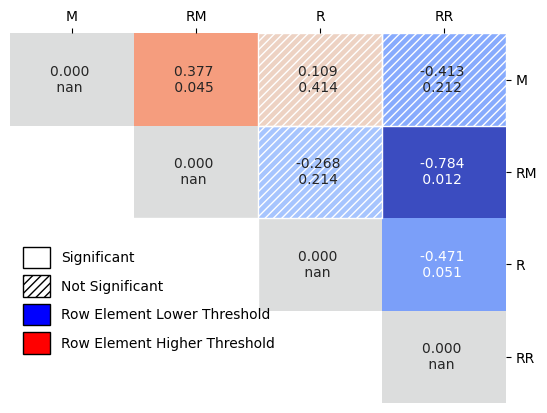

In [199]:
ind = laterality_r

### GET MEAN TO PLOT
p_mean = t.mean(axis=-1)
### GET P VALUES
p = test.pvalue
### MASK NANs
p_mean = p_mean.data
# p_mean = p_mean.reshape(len(ind),len(ind))

# ### GET VALUES WE WANT TO PLOT
p_ = p

#FOR ANNOTATION
data = []
for ind_i, i in enumerate(p_):
    for ind_j, j in enumerate(i):
        data.append(f"{p_mean[ind_i, ind_j]:.3f} \n {j:.3f}  ")
        
data = np.array(data).reshape(len(ind),len(ind))

#MASK LOWER TRIANGLE
mask2= np.array(p_)
mask2 = np.tril(np.ones_like(mask2), k=-1).astype(bool)

#CORRECT LABELS
labels = np.array(laterality_r)
labels = labels.astype('U20')

#PLOT
ax=sns.heatmap(p_mean   , xticklabels=labels, yticklabels=labels,annot=data,fmt = '',center = 0, cmap = "coolwarm",cbar = False, mask = mask2)


##ADD HATCH FOR SIGNIFICANCE
handles = []
hatch_mask = p_ > 0.1

for i in range (p_.shape[0]):
    for j in range(p_.shape[1]):
        if hatch_mask[i, j]:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='', label="Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='////', label="Not Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                    hatch='', label="Row Element Lower Threshold"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                    hatch='', label="Row Element Higher Threshold"))
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
        handlelength=2, handleheight=2, frameon=False)
ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

ax.yaxis.tick_right()

In [197]:
p_mean.data

array([[ 0.        ,  0.37659004,  0.10851392, -0.41292925],
       [-0.37659004,  0.        , -0.26777451, -0.78385504],
       [-0.10851392,  0.26777451,  0.        , -0.47064796],
       [ 0.41292925,  0.78385504,  0.47064796,  0.        ]])